In [1]:
# === Cell 1: Setup & Load Data ===

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import joblib

# Load dataset
df = pd.read_csv(r"C:\Users\allur\OneDrive\Desktop\project\customer_churn_sample_3000.csv")

# Drop non-predictive ID column
if 'customerID' in df.columns:
    df.drop('customerID', axis=1, inplace=True)

# Convert TotalCharges to numeric
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Map target variable
TARGET = 'Churn'
df[TARGET] = df[TARGET].map({'Yes': 1, 'No': 0})

# Check for missing target values
if df[TARGET].isna().any():
    raise ValueError("Target variable contains NaNs.")

# Separate features
num_cols = df.select_dtypes(include=np.number).columns.drop(TARGET, errors='ignore').tolist()
cat_cols = [c for c in df.columns if c not in num_cols + [TARGET]]

# Train-validation-test split
X = df[num_cols + cat_cols]
y = df[TARGET]
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Data ready — Train: {X_train.shape}, Valid: {X_valid.shape}, Test: {X_test.shape}")


Data ready — Train: (2100, 19), Valid: (450, 19), Test: (450, 19)


In [2]:
# === Cell 2: Feature Engineering ===

df_fe_train = X_train.copy()
df_fe_valid = X_valid.copy()
df_fe_test = X_test.copy()

# 1️⃣ Interaction Features
df_fe_train['charges_per_tenure'] = df_fe_train['MonthlyCharges'] * df_fe_train['tenure']
df_fe_valid['charges_per_tenure'] = df_fe_valid['MonthlyCharges'] * df_fe_valid['tenure']
df_fe_test['charges_per_tenure'] = df_fe_test['MonthlyCharges'] * df_fe_test['tenure']

# 2️⃣ High Monthly Charges flag (based on SHAP impact)
high_monthly_threshold = df_fe_train['MonthlyCharges'].median()
df_fe_train['high_monthly'] = (df_fe_train['MonthlyCharges'] > high_monthly_threshold).astype(int)
df_fe_valid['high_monthly'] = (df_fe_valid['MonthlyCharges'] > high_monthly_threshold).astype(int)
df_fe_test['high_monthly'] = (df_fe_test['MonthlyCharges'] > high_monthly_threshold).astype(int)

# 3️⃣ Simplify PaymentMethod categories
def simplify_payment_method(val):
    if 'electronic check' in val.lower():
        return 'Electronic'
    elif 'credit' in val.lower():
        return 'Credit Card'
    elif 'mailed' in val.lower():
        return 'Mailed Check'
    else:
        return 'Bank Transfer'

for df_part in [df_fe_train, df_fe_valid, df_fe_test]:
    if 'PaymentMethod' in df_part.columns:
        df_part['PaymentMethod_simple'] = df_part['PaymentMethod'].apply(simplify_payment_method)

print("Feature engineering complete.")
print("New columns added: charges_per_tenure, high_monthly, PaymentMethod_simple")


Feature engineering complete.
New columns added: charges_per_tenure, high_monthly, PaymentMethod_simple


In [3]:
# === Cell 3: Update preprocessor for new features + retrain XGBoost ===
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from xgboost import XGBClassifier
import numpy as np
import joblib, os

# 1) Recompute feature lists after engineering
num_cols_fe = df_fe_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols_fe = [c for c in df_fe_train.columns if c not in num_cols_fe]

print("Numeric (FE) cols:", num_cols_fe)
print("Categorical (FE) cols:", cat_cols_fe)

# 2) Build the preprocessor (same pattern as before)
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
try:
    cat_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])
except TypeError:
    cat_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse=False))
    ])

preprocessor_fe = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols_fe),
        ("cat", cat_pipe, cat_cols_fe),
    ],
    remainder="drop"
)

# 3) Class imbalance weight for XGB (computed on TRAIN)
pos = int((y_train == 1).sum())
neg = int((y_train == 0).sum())
scale_pos = neg / max(pos, 1)

# 4) Define model (same baseline but with engineered features)
xgb_model_fe = XGBClassifier(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=scale_pos
)

pipe_fe = Pipeline([
    ("preprocessor", preprocessor_fe),
    ("model", xgb_model_fe),
])

# 5) Fit on TRAIN (engineered features) and evaluate on VALID
pipe_fe.fit(df_fe_train, y_train)

val_proba = pipe_fe.predict_proba(df_fe_valid)[:, 1]
val_pred  = (val_proba >= 0.5).astype(int)

print("\n=== XGBoost w/ engineered features (Validation) ===")
print("Accuracy:", round(accuracy_score(y_valid, val_pred), 4))
print("F1     :", round(f1_score(y_valid, val_pred), 4))
print("ROC-AUC:", round(roc_auc_score(y_valid, val_proba), 4))
print("\nReport:\n", classification_report(y_valid, val_pred))

# 6) Save this updated pipeline
os.makedirs("models", exist_ok=True)
joblib.dump(pipe_fe, "models/xgb_pipeline_fe.joblib")
print("Saved: models/xgb_pipeline_fe.joblib")


Numeric (FE) cols: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'charges_per_tenure', 'high_monthly']
Categorical (FE) cols: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'PaymentMethod_simple']

=== XGBoost w/ engineered features (Validation) ===
Accuracy: 0.52
F1     : 0.52
ROC-AUC: 0.5282

Report:
               precision    recall  f1-score   support

           0       0.52      0.52      0.52       225
           1       0.52      0.52      0.52       225

    accuracy                           0.52       450
   macro avg       0.52      0.52      0.52       450
weighted avg       0.52      0.52      0.52       450

Saved: models/xgb_pipeline_fe.joblib


In [4]:
# === Cell 4: Evaluate engineered-features model on TEST set ===
import joblib
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

# 1) Load the saved pipeline
pipe_fe_loaded = joblib.load("models/xgb_pipeline_fe.joblib")

# 2) Predict on TEST
test_proba = pipe_fe_loaded.predict_proba(df_fe_test)[:, 1]
test_pred  = (test_proba >= 0.5).astype(int)

# 3) Print metrics
print("\n=== Final XGBoost w/ engineered features (Test Set) ===")
print("Accuracy:", round(accuracy_score(y_test, test_pred), 4))
print("F1     :", round(f1_score(y_test, test_pred), 4))
print("ROC-AUC:", round(roc_auc_score(y_test, test_proba), 4))
print("\nReport:\n", classification_report(y_test, test_pred))



=== Final XGBoost w/ engineered features (Test Set) ===
Accuracy: 0.5156
F1     : 0.5177
ROC-AUC: 0.5123

Report:
               precision    recall  f1-score   support

           0       0.51      0.51      0.51       224
           1       0.52      0.52      0.52       226

    accuracy                           0.52       450
   macro avg       0.52      0.52      0.52       450
weighted avg       0.52      0.52      0.52       450



c:\Users\allur\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SHAP sample shape: (500, 51) | features: 51


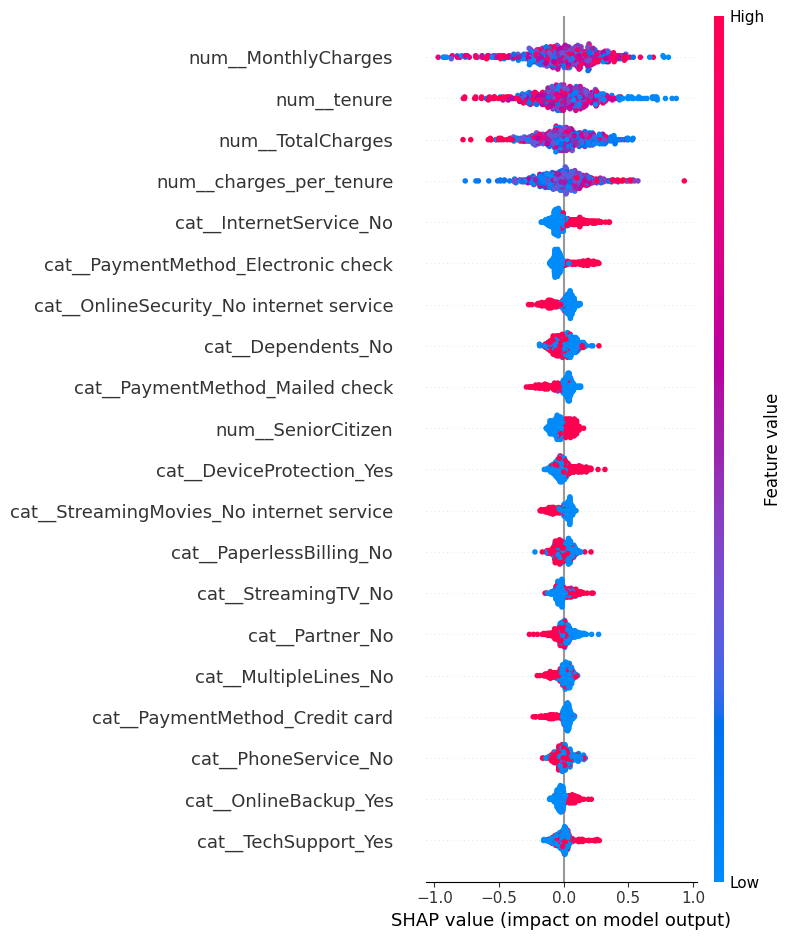

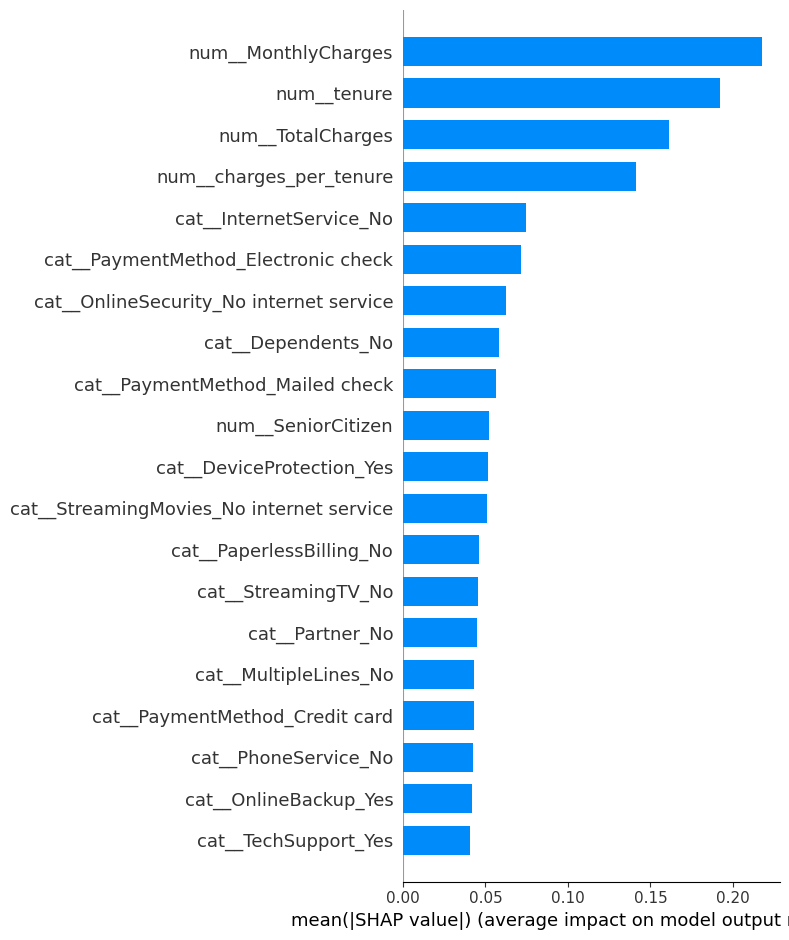

<Figure size 640x480 with 0 Axes>

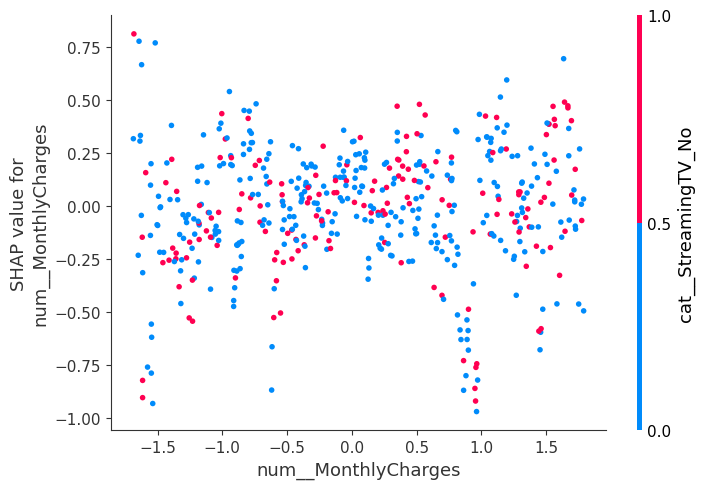


Saved:
 - reports/figures/shap_fe_beeswarm.png
 - reports/figures/shap_fe_feature_importance.png
 - reports/figures/shap_fe_dependence_num__MonthlyCharges.png
 - reports/top20_shap_features_fe.csv


In [5]:
# === Cell 5: SHAP on engineered-features model (pipe_fe) ===
import os, numpy as np, pandas as pd
import shap
import matplotlib.pyplot as plt
import joblib

# 1) Load the engineered-features pipeline (or reuse pipe_fe if it exists)
pipe_fe_loaded = joblib.load("models/xgb_pipeline_fe.joblib") if 'pipe_fe' not in globals() else pipe_fe
preproc_fe = pipe_fe_loaded.named_steps['preprocessor']
xgb_fe     = pipe_fe_loaded.named_steps['model']

# 2) Build a sample (mix train/valid/test FE frames) for faster SHAP
X_all_fe = pd.concat([df_fe_train, df_fe_valid, df_fe_test], axis=0)
X_sample_fe = X_all_fe.sample(n=min(500, len(X_all_fe)), random_state=42)

# Transform with the already-fitted preprocessor
X_sample_fe_trans = preproc_fe.transform(X_sample_fe)

# 3) Get post-preprocessing feature names
try:
    feat_names_fe = preproc_fe.get_feature_names_out()
except Exception:
    # Fallback: try to build names manually
    num_cols_fe = preproc_fe.transformers_[0][2]
    try:
        ohe = preproc_fe.named_transformers_['cat'].named_steps['ohe']
        cat_cols_fe = preproc_fe.transformers_[1][2]
        cat_names_fe = ohe.get_feature_names_out(cat_cols_fe).tolist()
    except Exception:
        cat_names_fe = [f"{c}_<onehot>" for c in preproc_fe.transformers_[1][2]]
    feat_names_fe = np.array(list(num_cols_fe) + cat_names_fe)

print("SHAP sample shape:", X_sample_fe_trans.shape, "| features:", len(feat_names_fe))

# 4) Compute SHAP values (TreeExplainer for XGBoost)
shap.initjs()
explainer_fe = shap.TreeExplainer(xgb_fe)
shap_values_fe = explainer_fe(X_sample_fe_trans)

# 5) Save plots
os.makedirs("reports/figures", exist_ok=True)

# Beeswarm (global impact + direction)
plt.figure()
shap.summary_plot(shap_values_fe, features=X_sample_fe_trans, feature_names=feat_names_fe, show=False)
plt.tight_layout()
plt.savefig("reports/figures/shap_fe_beeswarm.png", dpi=150)
plt.show()

# Bar plot (mean |SHAP|)
plt.figure()
shap.summary_plot(shap_values_fe, features=X_sample_fe_trans, feature_names=feat_names_fe, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig("reports/figures/shap_fe_feature_importance.png", dpi=150)
plt.show()

# Dependence plot on the most important feature
top_idx = np.argsort(np.abs(shap_values_fe.values).mean(axis=0))[-1]
top_feat = feat_names_fe[top_idx]
plt.figure()
shap.dependence_plot(top_feat, shap_values_fe.values, X_sample_fe_trans, feature_names=feat_names_fe, show=False)
plt.tight_layout()
plt.savefig(f"reports/figures/shap_fe_dependence_{top_feat}.png", dpi=150)
plt.show()

# 6) Export top-20 features by mean(|SHAP|)
imp = np.abs(shap_values_fe.values).mean(axis=0)
imp_df = pd.DataFrame({"feature": feat_names_fe, "mean_abs_shap": imp}).sort_values("mean_abs_shap", ascending=False)
imp_df.head(20).to_csv("reports/top20_shap_features_fe.csv", index=False)

print("\nSaved:")
print(" - reports/figures/shap_fe_beeswarm.png")
print(" - reports/figures/shap_fe_feature_importance.png")
print(f" - reports/figures/shap_fe_dependence_{top_feat}.png")
print(" - reports/top20_shap_features_fe.csv")


In [6]:
# === Cell 6: Threshold tuning on validation, then evaluate on test ===
import numpy as np
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score, roc_auc_score,
    confusion_matrix
)
import joblib

# Reload the engineered pipeline just to be safe
pipe_fe_loaded = joblib.load("models/xgb_pipeline_fe.joblib")

# 1) Get validation probabilities
val_proba = pipe_fe_loaded.predict_proba(df_fe_valid)[:, 1]

# 2) Sweep thresholds and pick best by F1 (change metric if you prefer)
thresholds = np.linspace(0.10, 0.90, 81)
records = []
for t in thresholds:
    pred = (val_proba >= t).astype(int)
    rec = {
        "threshold": t,
        "precision": precision_score(y_valid, pred, zero_division=0),
        "recall":    recall_score(y_valid, pred, zero_division=0),
        "f1":        f1_score(y_valid, pred, zero_division=0),
        "accuracy":  accuracy_score(y_valid, pred)
    }
    records.append(rec)

import pandas as pd
thr_df = pd.DataFrame(records)
best_row = thr_df.loc[thr_df["f1"].idxmax()]   # pick the threshold with max F1
best_thr = float(best_row["threshold"])

print("\n=== Validation threshold sweep (showing best by F1) ===")
print(best_row)

# 3) Lock the threshold and evaluate on TEST
test_proba = pipe_fe_loaded.predict_proba(df_fe_test)[:, 1]
test_pred  = (test_proba >= best_thr).astype(int)

print(f"\n=== Test metrics with tuned threshold (t={best_thr:.3f}) ===")
print("Accuracy:", round(accuracy_score(y_test, test_pred), 4))
print("Precision:", round(precision_score(y_test, test_pred, zero_division=0), 4))
print("Recall   :", round(recall_score(y_test, test_pred, zero_division=0), 4))
print("F1       :", round(f1_score(y_test, test_pred, zero_division=0), 4))
print("ROC-AUC  :", round(roc_auc_score(y_test, test_proba), 4))  # unaffected by threshold

cm = confusion_matrix(y_test, test_pred)
print("\nConfusion matrix (test):\n", cm)

# (Optional) Save chosen threshold for reuse
import json, os
os.makedirs("models", exist_ok=True)
with open("models/xgb_pipeline_fe_threshold.json", "w") as f:
    json.dump({"threshold": best_thr}, f)
print("\nSaved tuned threshold to models/xgb_pipeline_fe_threshold.json")



=== Validation threshold sweep (showing best by F1) ===
threshold    0.190000
precision    0.508046
recall       0.982222
f1           0.669697
accuracy     0.515556
Name: 9, dtype: float64

=== Test metrics with tuned threshold (t=0.190) ===
Accuracy: 0.5044
Precision: 0.5034
Recall   : 0.9735
F1       : 0.6637
ROC-AUC  : 0.5123

Confusion matrix (test):
 [[  7 217]
 [  6 220]]

Saved tuned threshold to models/xgb_pipeline_fe_threshold.json
